# Syncing spike data with pycontrol

In [1]:
%reload_ext autoreload
%autoreload 2

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr
from trialexp.process.pycontrol import event_filters
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from trialexp.process.pycontrol.event_filters import *
sns.set_context('talk')

In [2]:
sel_probe = 'ProbeA'

In [3]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
# path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/ephys/sorting')
path

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/ephys/sorting')

In [4]:
path.parents[1]

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254')

In [5]:
figure_output = path.parents[1]/'processed'/'figures'/'ephys'
figure_output

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/processed/figures/ephys')

In [6]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

# Manually get the start time for now
# TODO: fix the bug in create_folder
tstart = rec_properties[rec_properties.longest==True].tstart.iloc[0]
tstart

2336.4272

## Attempt to load the channel position from raw kilosort output


In [7]:
koutput_folder = path/'output'/sel_probe

In [8]:
templates = np.load(koutput_folder/'templates.npy')
templates.shape

(979, 82, 384)

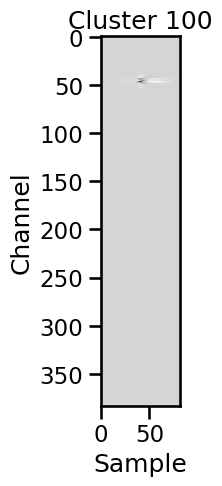

In [9]:
cluster_id = 100
plt.imshow(templates[cluster_id,:,:].T, cmap='gray');
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title(f'Cluster {cluster_id}');

In [10]:
peak_amp = np.max(abs(templates), axis=1)
channel_idx = np.argmax(peak_amp, axis=1)

# Data sync

In [11]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
# rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
rsync = create_sync_photo_ephys(photo_time, path.parent)
assert rsync is not None

In [12]:
#load the spike extractor
probe_sorting = si.load_extractor(path/sel_probe)

### Calculate depth of each channel

Text(0, 0.5, 'Channel')

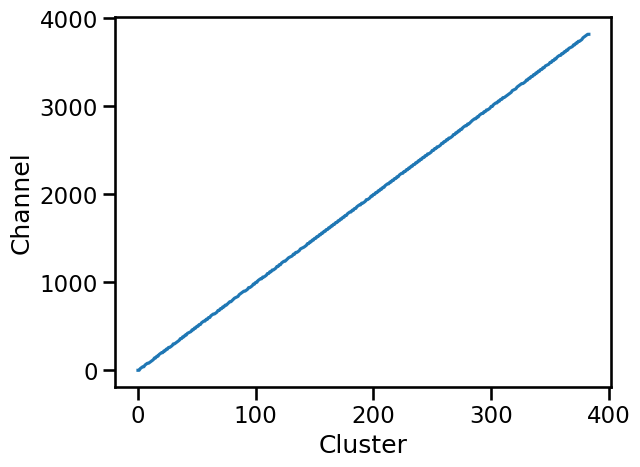

In [13]:
# rearrange the unit id such that they are in the same order as channel
# For each cluster, get its corresponding dominant channel
# then from the dominant channel number, we can calculate its depth, each row has 2 contact, and each row is 20um high
unit_ids = probe_sorting.get_unit_ids()
idx = np.argsort(channel_idx)
unit_ids_sorted = unit_ids[idx] #
chan_idx_sorted = channel_idx[idx]
cluster_depth = chan_idx_sorted//2*20 
plt.plot(chan_idx_sorted, cluster_depth)
plt.xlabel('Cluster')
plt.ylabel('Channel')

In [14]:
# Sync and  all the sorting to ms
# spike time from kilosort count from the beginning of the recording
# where the rsync time count from the beginning of the open ephys session
# so we need to shift the spike time to the ephys rsync time unit first

def get_sorting_spiketime(sorting,rsync,tstart, Fs=30000):
    spike_times = []
    max_time = 0
    for id in tqdm(unit_ids_sorted):
        ks_label = probe_sorting.get_unit_property(id, 'KSLabel') # for future
        spk_time = probe_sorting.get_unit_spike_train(id)
        spk_time = (spk_time/Fs+tstart)*1000 #need to shift by the starting time of recording
        spk_time = rsync.A_to_B(spk_time)

        if len(spk_time)>0:
            max_time = max(max_time, spk_time[-1])
        spike_times.append(spk_time)
    return spike_times

spike_times = get_sorting_spiketime(probe_sorting, rsync, tstart)
print(len(spike_times))

  0%|          | 0/979 [00:00<?, ?it/s]

979


In [15]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [16]:
# convert spike timing to firing rate
def calculate_spike_rate(spike_times, bins, bin_size):
    spike_rates = np.zeros((len(bins)-1, len(spike_times)))
    for i in tqdm(range(len(spike_times))):
        count, _ = np.histogram(spike_times[i], bins) 
        spike_rates[:,i] = count * (1000/bin_size)
    return spike_rates

bin_size = 50
bins = np.append(xr_session.time.data, xr_session.time.data[-1]+50) # make sure we cover the whole range

spike_rates = calculate_spike_rate(spike_times, bins, bin_size)


  0%|          | 0/979 [00:00<?, ?it/s]

In [17]:
cluster_ids = probe_sorting.get_unit_ids()
xa_spike_rate = xr.DataArray(
    spike_rates, coords={'time':bins[:-1], 
                         'cluster_id':cluster_ids},
    dims=('time','cluster_id'))

xr_session['spike_rate'] = xa_spike_rate

Text(0.5, 1.0, 'ProbeA')

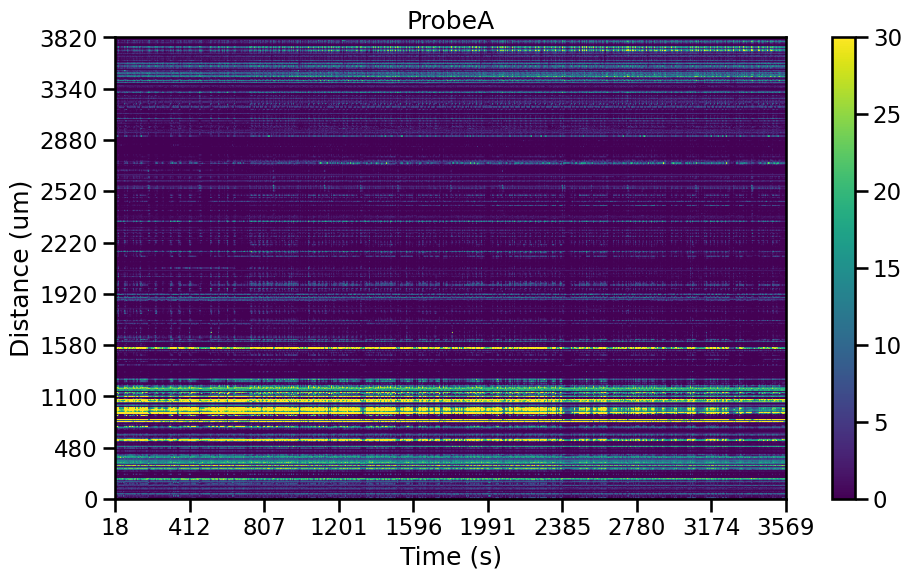

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.imshow(spike_rates.T, vmax=30)
plt.colorbar()
ax.set_aspect(50)

xticks = np.linspace(0,spike_rates.shape[0],10).astype(int)
ax.set_xticks(xticks);
labels = [f'{int(x)}' for x in bins[xticks]/1000]
ax.set_xticklabels(labels);

yticks = np.linspace(0,spike_rates.shape[1]-1,10).astype(int)

ax.set_yticks(yticks)
ax.set_yticklabels(cluster_depth[yticks])

ax.set_ylabel('Distance (um)');
ax.set_xlabel('Time (s)')
ax.invert_yaxis()
ax.set_title(sel_probe)
# plt.savefig(figure_output/f'{sel_probe}_time_all.png', dpi=300)

## Align spike data to events

In [19]:
df_pycontrol = pd.read_pickle(path.parents[1]/'processed'/'df_pycontrol.pkl')
rsync_time = df_pycontrol[df_pycontrol.name=='rsync'].time
pyphoto_aligner = Rsync_aligner(pulse_times_A= rsync_time, 
                pulse_times_B= photo_time, plot=False) #align pycontrol time to pyphotometry time


In [20]:
df_event = pd.read_pickle(path.parents[1]/'processed'/'df_events_cond.pkl')
trial_window = df_event.attrs['trial_window']
dataset = xr_session.copy()

## Closer look at the tip of the recording

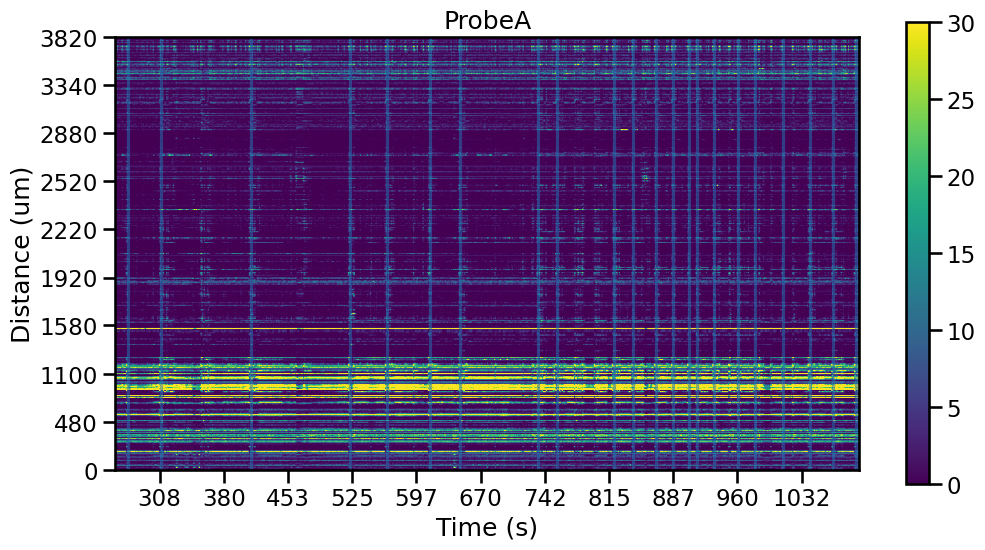

In [24]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
spike_rate2plot = spike_rates

plt.imshow(spike_rate2plot.T, vmax=30)
plt.colorbar()
ax.set_aspect(10)

xticks = np.linspace(0,spike_rate2plot.shape[0],50).astype(int)
ax.set_xticks(xticks);
labels = [f'{int(x)}' for x in bins[xticks]/1000]
ax.set_xticklabels(labels);

yticks = np.linspace(0,spike_rate2plot.shape[1]-1,10).astype(int)

ax.set_yticks(yticks)
ax.set_yticklabels(cluster_depth[yticks])

ax.set_ylabel('Distance (um)');
ax.set_xlabel('Time (s)')
ax.invert_yaxis()
ax.set_title(sel_probe)



# add in the trigger location
# event_time = extract_event_time(df_event, event_filters.get_first_event_from_name, {'evt_name':'hold_for_water'})
event_time = extract_event_time(df_event, event_filters.get_first_spout, {})


event_time = pyphoto_aligner.A_to_B(event_time)
for t in event_time:
    idx = np.argmin(abs(xr_session.time.data-t))
    ax.axvline(idx, alpha=0.5)
    
# ax.set_ylim([0,500])
ax.set_xlim([20*60*4, 20*60*18])
plt.savefig(figure_output/f'{sel_probe}_time_all_aligned_first_spout.png', dpi=300)


